In [5]:
%matplotlib inline

import sys
sys.path.insert(0,'/Users/andrew/Library/Python/2.7/lib/python/site-packages/')

import gym
import matplotlib
import numpy as np

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 

from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [6]:
env = BlackjackEnv()

In [17]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        probs = np.zeros(nA)
        if np.random.random_sample() > epsilon:
            probs[np.argmax(Q[observation])] = 1.0
        else:
            probs[np.random.randint(nA)] = 1.0
        return probs
        # Implement this!
    return policy_fn

In [25]:
epsilon=0.1
state = env.reset()
Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
avgs = np.zeros(env.action_space.n)
count = 1000
for x in range(count):
    probs = policy(state)
    avgs += probs
print avgs / count

[ 0.959  0.041]


In [26]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function taht takes an observation as an argument and returns
        action probabilities
        
        Initialize, for all s ∈ S, a ∈ A(s):
            Q(s, a) ← arbitrary
            π(s) ← arbitrary
            Returns(s, a) ← empty list

        Repeat forever:
            Choose S0 ∈ S and A0 ∈ A(S0) s.t. all pairs have probability > 0
            Generate an episode starting from S0,A0, following π
            For each pair s, a appearing in the episode:
                G ← return following the first occurrence of s, a
                Append G to Returns(s, a)
                Q(s, a) ← average(Returns(s, a))
            For each s in the episode: π(s) ← arg maxa Q(s, a)
 
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    actions = np.array(xrange(env.action_space.n))

    for ep in range(num_episodes):
        observation = env.reset()
        discount_pow = 0
        episode_states = {}
        for t in range(100):
            action_dist = policy(observation)
            action = np.random.choice(actions, p=action_dist)
            observation, reward, done, _ = env.step(action)
            if observation not in episode_states:
                episode_states[observation] = 0
            for state in episode_states:
                episode_states[state] += (discount_factor ** discount_pow) * reward
            if done:
                break
            discount_pow += 1
        for state in episode_states:
            returns_sum[state] += episode_states[state]
            returns_count[state] += 1
            Q[state] = returns_sum[state] / returns_count[state]
        
            
    return Q, policy

In [27]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

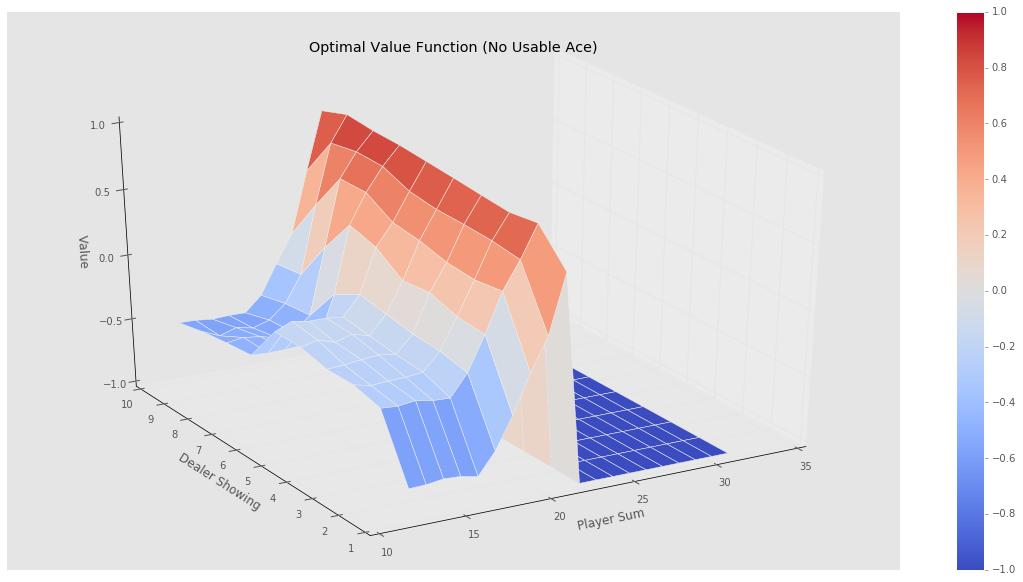

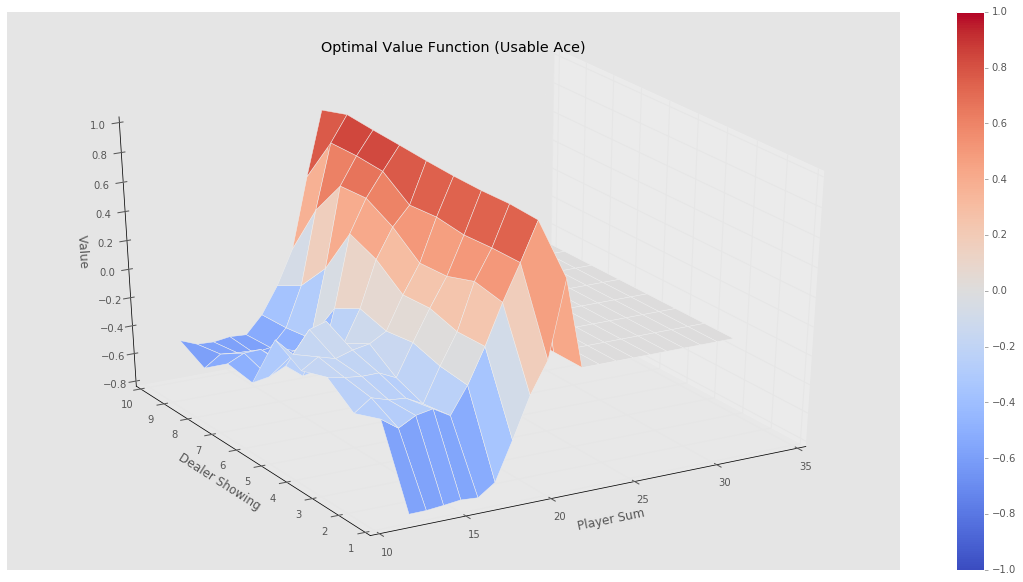

In [28]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")